In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.ticker as ticker

from scipy.signal import hilbert

import pandas as pd

import py.continuum1d as continuum1d
c1d = continuum1d.continuum1d()

from py.params import setParams
from py.analysis import computeFPs, checkFixPtsStability, violationType, a_jkValues, lmbd
from py.turings import checkStability
from py.funcs import getSwitchIndex

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

1d Model initialised.


In [2]:
# explicit function to normalize array (for visualisation reasons - very helpful!)
def normalize(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr

In [3]:
b1_lats = pd.read_csv('phase_lats/ee047_ii001_b.csv')
b2_lats = pd.read_csv('phase_lats/ee04_ii_minus014_b.csv')
b3_lats = pd.read_csv('phase_lats/ee02_ii_minus025_b.csv')
b5_lats = pd.read_csv('phase_lats/ee039_ii_minus004_b.csv')
b4_lats = pd.read_csv('phase_lats/ee01_ii_minus055_b.csv')

all_b_dfs = [b1_lats, b2_lats, b3_lats, b4_lats]

In [4]:
tau1_lats = pd.read_csv('phase_lats/ee047_ii001_tau.csv')
tau2_lats = pd.read_csv('phase_lats/ee04_ii_minus014_tau.csv')
tau3_lats = pd.read_csv('phase_lats/ee02_ii_minus025_tau.csv')
tau5_lats = pd.read_csv('phase_lats/ee039_ii_minus004_tau.csv')
tau4_lats = pd.read_csv('phase_lats/ee01_ii_minus055_tau.csv')

all_tau_dfs = [tau1_lats, tau2_lats, tau3_lats, tau4_lats]
tau4_lats

,Unnamed: 0,#time_steps,#nodes
0,10.0,18.0,0.0
1,300.0,30.0,0.0
2,600.0,38.0,0.0
3,900.0,23.0,0.0
4,1200.0,3.0,0.0
5,1500.0,31.0,0.0
6,1800.0,7.0,0.0
7,2100.0,33.0,0.0
8,2400.0,9.0,0.0
9,2700.0,33.0,0.0


In [5]:
def compute_avg(all_dfs):
    #all_b_dfs = [b1_lats, b2_lats, b3_lats]
    all_times = np.zeros(len(all_dfs[0]['#time_steps']))
    all_nodes = np.zeros(len(all_dfs[0]['#nodes']))

    for df in all_dfs:
        all_times += df['#time_steps'].to_numpy()
        all_nodes += df['#nodes'].to_numpy()

    avg_times = (1/len(all_dfs))*all_times
    avg_nodes = (1/len(all_dfs))*all_nodes
    avg = np.array([avg_times, avg_nodes]).T.reshape(len(avg_times),2)
    
    return avg

def compute_var(all_dfs, avg):
    #all_b_dfs = [b1_lats, b2_lats, b3_lats]
    all_times = np.zeros(len(all_dfs[0]['#time_steps']))
    all_nodes = np.zeros(len(all_dfs[0]['#nodes']))

    for df in all_dfs:
        var_time_val = (df['#time_steps'].to_numpy()-avg[:,0])*(df['#time_steps'].to_numpy()-avg[:,0])
        all_times += var_time_val
        var_nodes_val = (df['#nodes'].to_numpy()-avg[:,1])*(df['#nodes'].to_numpy()-avg[:,1])
        all_nodes += var_nodes_val

    var_times = (1/len(all_dfs))*all_times
    var_nodes = (1/len(all_dfs))*all_nodes
    var = np.array([var_times, var_nodes]).T.reshape(len(var_times),2)
    
    return var

In [6]:
#compute the average amount of time steps and nodes per τ_a valueover all 4 different (I_e,I_i)-combinations:
tau_avg = compute_avg(all_tau_dfs)
tau_var = compute_var(all_tau_dfs, tau_avg)

In [7]:
#divide times & nodes by their own maximum value to set them into relation to themselves and keep the qualitative ϕ
taux = np.copy(tau_avg[:,0])
tauy = np.copy(tau_avg[:,1])
taux_max = taux/np.max(taux)
tauy_max = tauy/np.max(tauy)
tau_avg_max = np.array([taux_max, tauy_max]).T.reshape(len(tauy_max),2)

In [8]:
tau_time = taux_max
tau_space = tauy_max
tau_angles = np.arctan2(tauy_max, taux_max)
tau_degs = np.degrees(tau_angles)

In [9]:
tau_var_time = tau_var[:,0]/np.max(tau_var[:,0])
tau_var_space = tau_var[:,1]/np.max(tau_var[:,1])

tau_var_max = np.array([tau_var_time, tau_var_space]).T.reshape(len(tau_var_space),2)

tau_var_degrees = np.zeros((21,4))

for i, df in enumerate(all_tau_dfs):
    spacy = df['#nodes'].to_numpy()/np.max(df['#nodes'].to_numpy())
    timx = df['#time_steps'].to_numpy()/np.max(df['#time_steps'].to_numpy())
    if any(np.isnan(spacy)):
        for j in range(len(spacy)):
            spacy[j]=0
    print(spacy, timx)
    tau_var_angles = np.arctan2(spacy, timx)
    tau_var_degs = np.degrees(tau_var_angles)

    tau_var_degrees.T[i] = tau_var_degs

tau_var_degrees = np.var(tau_var_degrees, axis=1)
tau_var_degrees

[0.08 1.   0.84 0.84 0.84 0.84 0.84 0.84 0.84 0.84 0.84 0.84 0.84 0.84
 0.8  0.84 0.84 0.84 0.84 0.84 0.72] [1.         0.13551124 0.18404752 0.22121341 0.26338566 0.28476877
 0.31175223 0.34102673 0.38277471 0.3906661  0.42876538 0.42571065
 0.44955452 0.47730165 0.46084005 0.46991939 0.53305049 0.5321171
 0.55273653 0.5579126  0.55239711]
[0.80645161 1.         0.80645161 0.67741935 0.67741935 0.67741935
 0.67741935 0.67741935 0.67741935 0.67741935 0.67741935 0.67741935
 0.58064516 0.67741935 0.67741935 0.67741935 0.67741935 0.67741935
 0.67741935 0.67741935 0.67741935] [0.05952891 0.22412562 0.31563169 0.37016417 0.4455389  0.475803
 0.51734475 0.57159172 0.63882941 0.64211278 0.70992148 0.71763026
 0.717202   0.77216274 0.78643826 0.78315489 0.88336902 0.88850821
 1.         0.9076374  0.99400428]
[1.         0.80645161 0.80645161 0.67741935 0.80645161 0.67741935
 0.80645161 0.67741935 0.67741935 0.67741935 0.67741935 0.67741935
 0.67741935 0.67741935 0.67741935 0.67741935 0.677419

/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1385/1187699145.py:9: RuntimeWarning: invalid value encountered in true_divide
  spacy = df['#nodes'].to_numpy()/np.max(df['#nodes'].to_numpy())


array([1760.15360588, 1149.17083135,  973.92161685,  845.69563039,
        785.94607967,  726.85306325,  704.66318599,  637.70326757,
        583.18099421,  576.42996357,  532.12942219,  531.60118811,
        502.22903145,  483.4481387 ,  477.9207976 ,  485.5373259 ,
        434.29008744,  433.47838817,  412.21465562,  415.4961348 ,
        355.58686019])

In [10]:
tau_row = [tau_degs[1:], tau_time[1:], tau_space[1:]]
fac = 0.1 #for visualisation reasons I scale the variance
tau_var_row = [tau_var_degrees[1:]*fac/2, tau_var_time[1:]/2, tau_var_space[1:]/2]

In [11]:
#compute the average amount of time steps and nodes per b value over all 4 different (I_e,I_i)-combinations:
b_avg = compute_avg(all_b_dfs)

#This computes the variance over the four (I_e,I_i)-combinations but I can't read anything from it
#unless I find a way to representably average it or similar:
b_var = compute_var(all_b_dfs, b_avg)

In [12]:
#divide times & nodes by their own maximum value to set them into relation to themselves and keep the qualitative ϕ
bx = np.copy(b_avg[:,0])
by = np.copy(b_avg[:,1])
bx_max = bx/np.max(bx)
by_max = by/np.max(by)
b_avg_max = np.array([bx_max, by_max]).T.reshape(len(by_max),2)

In [13]:
b_time = bx_max
b_space = by_max
b_angles = np.arctan2(by_max, bx_max)
b_degs = np.degrees(b_angles)

In [14]:
b_var_time = b_var[:,0]/np.max(b_var[:,0])
b_var_space = b_var[:,1]/np.max(b_var[:,1])

b_var_max = np.array([b_var_time, b_var_space]).T.reshape(len(b_var_space),2)

b_var_degrees = np.zeros((21,4))
for i, df in enumerate(all_b_dfs):
    spacy = df['#nodes'].to_numpy()/np.max(df['#nodes'].to_numpy())
    timx = df['#time_steps'].to_numpy()/np.max(df['#time_steps'].to_numpy())
    b_var_angles = np.arctan2(spacy, timx)
    b_var_degs = np.degrees(b_var_angles)

    b_var_degrees.T[i] = b_var_degs

b_var_degrees = np.var(b_var_degrees, axis=1)

In [15]:
b_row = [b_degs[1:], b_time[1:], b_space[1:]]
b_var_row = [b_var_degrees[1:]*0.001, b_var_time[1:]/2, b_var_space[1:]/2]

/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1385/542274259.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=[0.05, 0.2, 0.35, 0.5], fontsize=fs)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1385/542274259.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=np.round(np.linspace(min(b_row[ind]), max(b_row[ind]), 4),
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1385/542274259.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=[0.05, 0.2, 0.35, 0.5], fontsize=fs)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1385/542274259.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=np.round(np.linspace(min(b_row[ind]), max(b_row[ind]), 4),
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1385/54227425

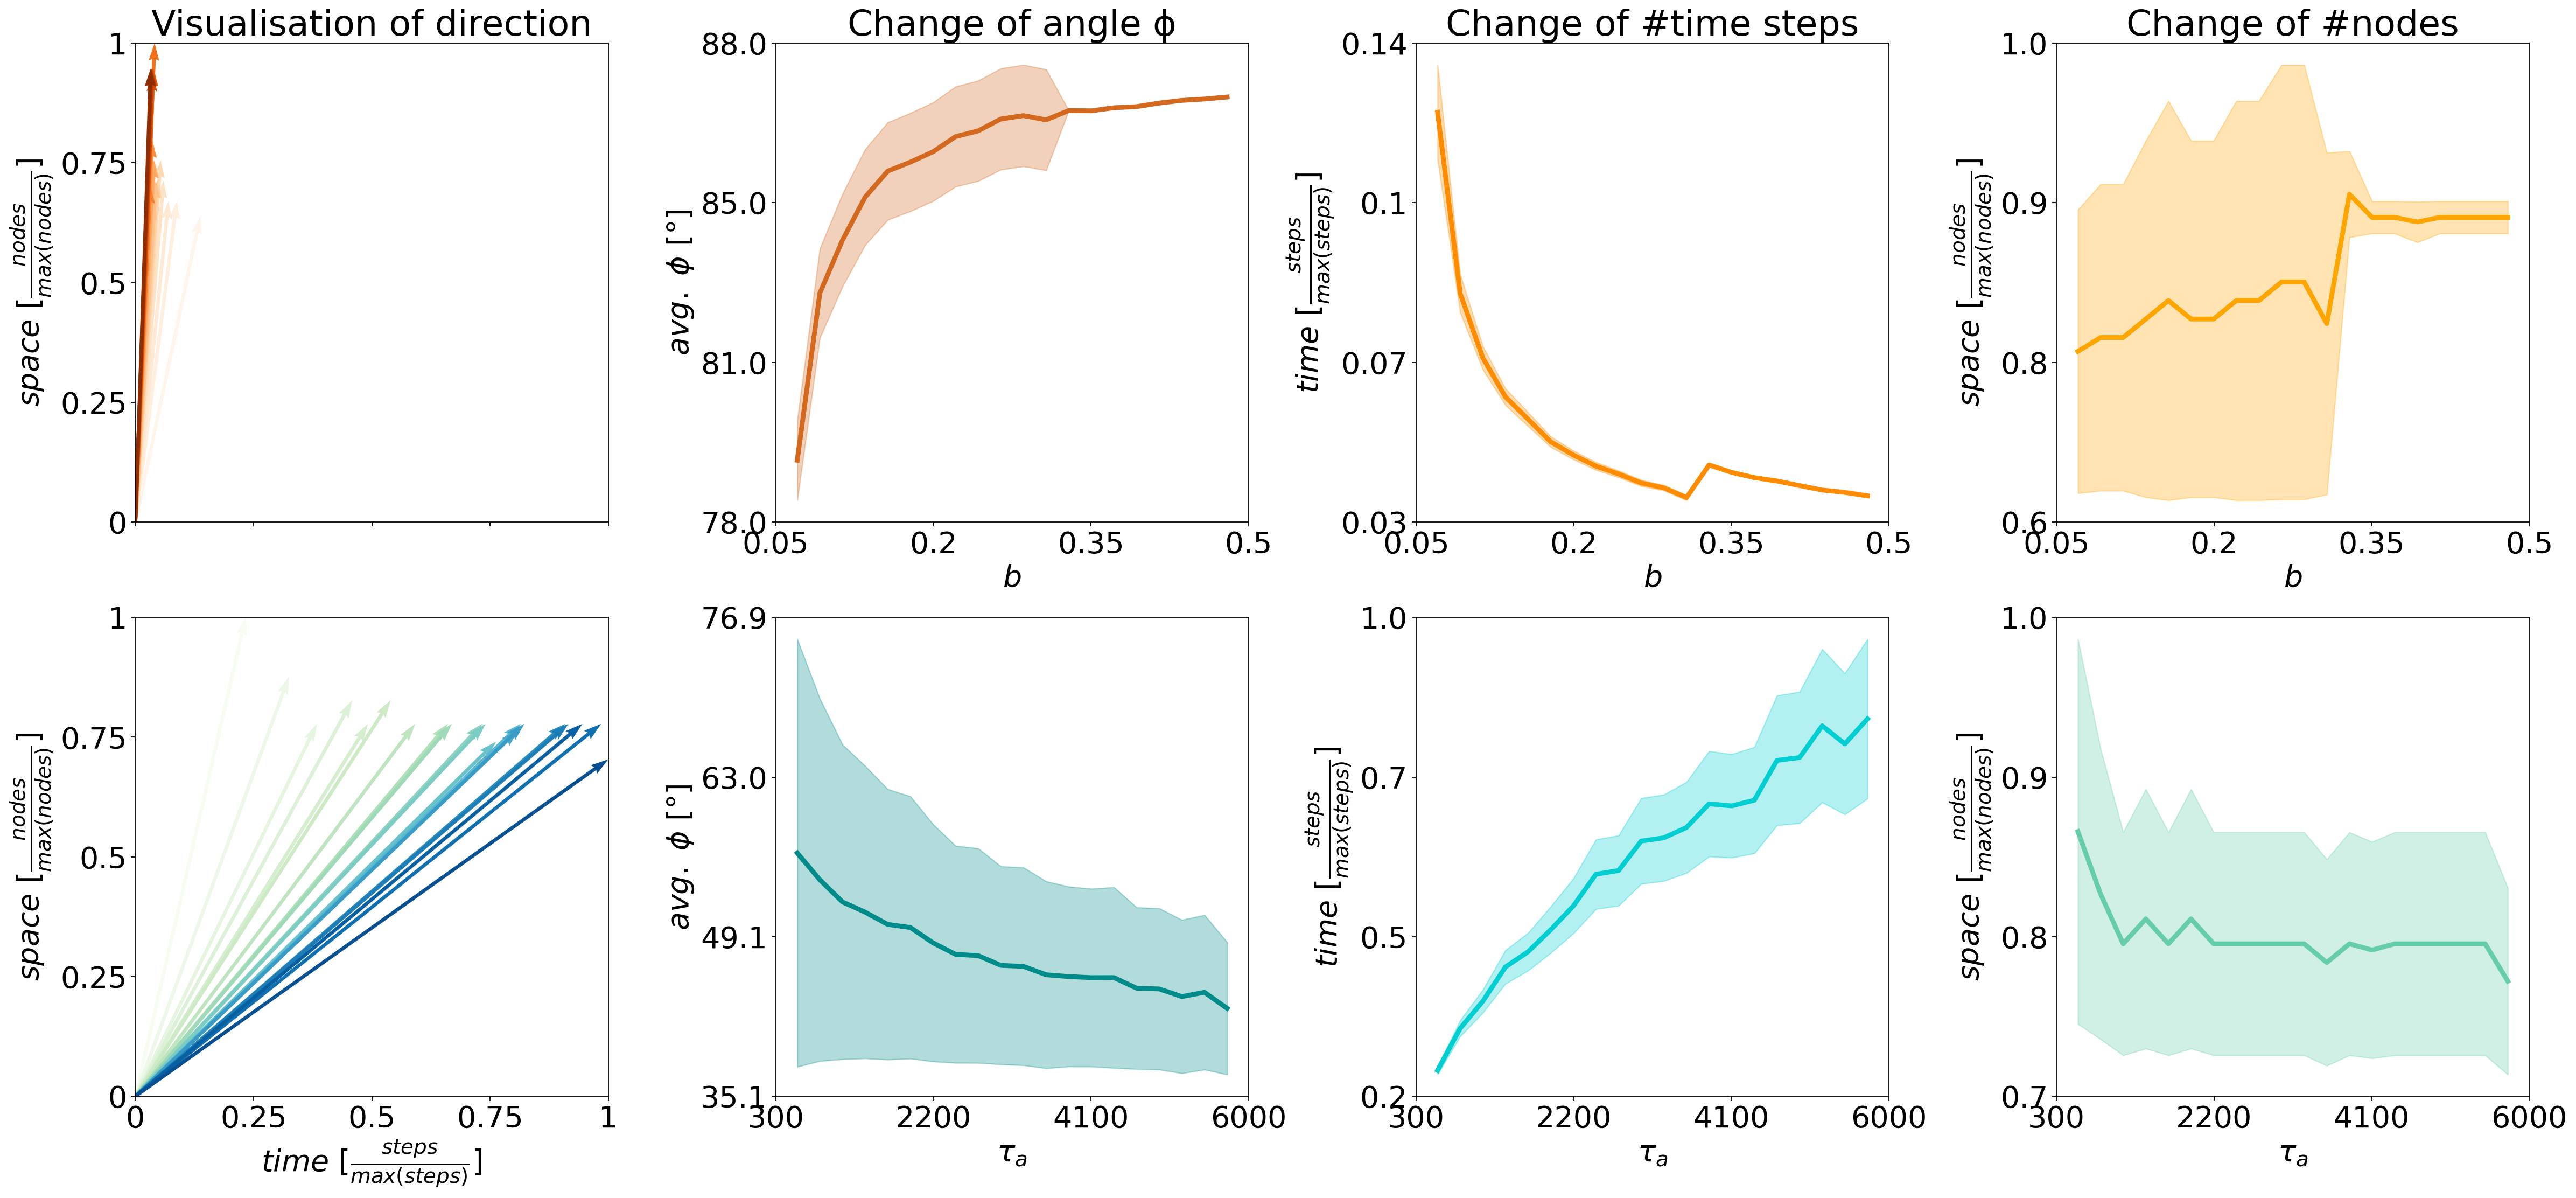

In [16]:
fig, ((ax0, ax1, ax2, ax3), (ax4, ax5, ax6, ax7)) = plt.subplots(2, 4, figsize=(30,14), dpi=160)

oranges=['chocolate', 'darkorange', 'orange']
turquoises = ['darkcyan', 'darkturquoise', 'mediumaquamarine']

colors_b = cm.get_cmap('Oranges', len(b_avg))
colors_tau = cm.get_cmap('GnBu', len(tau_avg))
ylabels = [r'$avg.\ \phi\ [\degree]$', 
           r'$time\ $' + r'$[\frac{steps}{max(steps)}]$', 
           r'$space\ $' + r'$[\frac{nodes}{max(nodes)}]$']
titles = ['Change of angle ϕ',
          'Change of #time steps',
          'Change of #nodes']

lw=4
fs=25

for ind, pair in enumerate(b_avg_max[1:,:]):
    ax0.quiver(0, 0, pair[0], pair[1], angles='xy', scale_units='xy', scale=1, 
               color=colors_b(ind))

ax0.set_title('Visualisation of direction', fontsize=fs+5)
    
for ind, pair in enumerate(tau_avg_max[1:,:]):
    ax4.quiver(0, 0, pair[0], pair[1], angles='xy', scale_units='xy', scale=1, 
               color=colors_tau(ind))

decimals_b = [0,2,1]

for ind, ax in enumerate([ax1, ax2, ax3]):
    ax.plot(b_row[ind], lw=lw, c=oranges[ind])
    
    # Plot the shaded region for variance (you can use std, 2*std, etc.)
    ax.fill_between(np.linspace(0,19,20), b_row[ind] - b_var_row[ind], b_row[ind] + b_var_row[ind], 
                    color=oranges[ind], alpha=0.3, label='Variance')

    
    #set x-axis labels
    ax.set_xlabel(r'$b$', fontsize=fs)
    ax.xaxis.set_major_locator(ticker.LinearLocator(4))
    ax.set_xticklabels(labels=[0.05, 0.2, 0.35, 0.5], fontsize=fs)
    
    #set y-axis labels
    ax.set_title(titles[ind], fontsize=fs+5)
    ax.set_ylabel(ylabels[ind], fontsize=fs)
    ax.yaxis.set_major_locator(ticker.LinearLocator(4))
    ax.set_yticklabels(labels=np.round(np.linspace(min(b_row[ind]), max(b_row[ind]), 4), 
                                       decimals=decimals_b[ind]), fontsize=fs)

values = ['#time_steps', '#nodes']
    
for ind, ax in enumerate([ax5, ax6, ax7]):
    ax.plot(tau_row[ind], lw=lw, c=turquoises[ind])
    
    # Plot the shaded region for variance (you can use std, 2*std, etc.)
    ax.fill_between(np.linspace(0,19,20), tau_row[ind] - tau_var_row[ind], tau_row[ind] + tau_var_row[ind], 
                    color=turquoises[ind], alpha=0.3, label='Variance')
    
    #set x-axis labels
    ax.set_xlabel(r'$\tau_a$', fontsize=fs)
    ax.xaxis.set_major_locator(ticker.LinearLocator(4))
    ax.set_xticklabels(labels=[300, 2200, 4100, 6000], fontsize=fs)
    
    #set y-axis labels
    ax.set_ylabel(ylabels[ind], fontsize=fs)
    ax.yaxis.set_major_locator(ticker.LinearLocator(4))
    ax.set_yticklabels(labels=np.round(np.linspace(min(tau_row[ind]), max(tau_row[ind]), 4), decimals=1), fontsize=fs)


for ax in [ax0, ax4]:
    ax.set_xlim([0, 1])
    ax.set_xlabel(ylabels[1], fontsize=fs)
    ax.xaxis.set_major_locator(ticker.LinearLocator(5))
    ax.set_xticklabels(labels=[0, 0.25, 0.5, 0.75, 1], fontsize=fs)
    ax.set_ylim([0, 1])
    ax.set_ylabel(ylabels[2], fontsize=fs)
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.set_yticklabels(labels=[0, 0.25, 0.5, 0.75, 1], fontsize=fs)
    
ax0.set_xticklabels(labels=[])
ax0.set_xlabel('')

plt.tight_layout()

fig.savefig('adap_features_phase.png')

In [17]:
ls0 = pd.read_csv('csv/a_features/adaps_features_case_i.csv')
ls1 = pd.read_csv('csv/a_features/adaps_features_case_ii.csv')
ls2 = pd.read_csv('csv/a_features/adaps_features_case_iii.csv')
ls3 = pd.read_csv('csv/a_features/adaps_features_case_iv.csv')

ls4 = pd.read_csv('csv/a_features/adaps_features_case_i.csv')
ls5 = pd.read_csv('csv/a_features/adaps_features_case_ii.csv')
ls6 = pd.read_csv('csv/a_features/adaps_features_case_iii.csv')
ls7 = pd.read_csv('csv/a_features/adaps_features_case_iv.csv')
ls0

,Unnamed: 0,b,tau_a,temp_dom_frequ,space_dom_frequ,down_duration,up_duration,down_space,up_space
0,0,0.000,1.0,0.000000,7.0,0.000000,0.000000,0.063895,0.078962
1,0,0.025,1.0,0.000000,7.0,0.000000,0.000000,0.065011,0.077846
2,0,0.050,1.0,0.000000,7.0,0.000000,0.000000,0.065848,0.077009
3,0,0.075,1.0,0.000000,7.0,0.000000,0.000000,0.066964,0.075893
4,0,0.100,1.0,0.000000,7.0,0.000000,0.000000,0.067801,0.075056
...,...,...,...,...,...,...,...,...,...
436,0,0.400,6000.0,0.916667,6.0,1.124109,1.057709,0.085286,0.081380
437,0,0.425,6000.0,0.950000,6.0,1.096454,1.008809,0.086589,0.080078
438,0,0.450,6000.0,0.983333,6.0,1.072542,0.961356,0.087240,0.079427
439,0,0.475,6000.0,1.033333,7.0,1.084935,0.850548,0.080078,0.062779


In [18]:
def add_ratio(df_array):
    
    for df in df_array:
        df_down_ratio = df['down_duration'].to_numpy()/(df['down_duration'].to_numpy() + df['up_duration'].to_numpy())
        df_up_ratio = df['up_duration'].to_numpy()/(df['down_duration'].to_numpy() + df['up_duration'].to_numpy())
        
        # Using DataFrame.insert() to add a column
        df.insert(6, "down_duration_ratio", df_down_ratio, True)
        df.insert(8, "up_duration_ratio", df_up_ratio, True)

In [19]:
def add_space_ratio(df_array):
    
    for df in df_array:
        df_down_ratio = df['down_space'].to_numpy()/(df['down_space'].to_numpy() + df['up_space'].to_numpy())
        df_up_ratio = df['up_space'].to_numpy()/(df['down_space'].to_numpy() + df['up_space'].to_numpy())
        
        # Using DataFrame.insert() to add a column
        df.insert(10, "down_space_ratio", df_down_ratio, True)
        df.insert(12, "up_space_ratio", df_up_ratio, True)

In [30]:
add_ratio(dfList1)
add_space_ratio(dfList1)

/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1385/1764694879.py:4: RuntimeWarning: invalid value encountered in true_divide
  df_down_ratio = df['down_duration'].to_numpy()/(df['down_duration'].to_numpy() + df['up_duration'].to_numpy())
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1385/1764694879.py:5: RuntimeWarning: invalid value encountered in true_divide
  df_up_ratio = df['up_duration'].to_numpy()/(df['down_duration'].to_numpy() + df['up_duration'].to_numpy())
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1385/1764694879.py:4: RuntimeWarning: invalid value encountered in true_divide
  df_down_ratio = df['down_duration'].to_numpy()/(df['down_duration'].to_numpy() + df['up_duration'].to_numpy())
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1385/1764694879.py:5: RuntimeWarning: invalid value encountered in true_divide
  df_up_ratio = df['up_duration'].to_numpy()/(df['down_duration'].to_numpy() + df['up_duration'].to_numpy())
/var

In [29]:
ls7

,Unnamed: 0,b,tau_a,temp_dom_frequ,space_dom_frequ,down_duration,down_duration_ratio,up_duration,up_duration_ratio,down_space,down_space_ratio,up_space,up_space_ratio
10,0,0.25,1.0,123.633333,0.0,0.006449,0.398668,0.009728,0.601332,0.0,NaN,0.0,NaN
31,0,0.25,300.0,101.933333,0.0,0.007602,0.387470,0.012018,0.612530,0.0,NaN,0.0,NaN
52,0,0.25,600.0,101.900000,0.0,0.007606,0.387517,0.012021,0.612483,0.0,NaN,0.0,NaN
73,0,0.25,900.0,101.900000,0.0,0.007606,0.387524,0.012021,0.612476,0.0,NaN,0.0,NaN
94,0,0.25,1200.0,101.900000,0.0,0.007606,0.387543,0.012021,0.612457,0.0,NaN,0.0,NaN
115,0,0.25,1500.0,101.900000,0.0,0.007606,0.387547,0.012021,0.612453,0.0,NaN,0.0,NaN
136,0,0.25,1800.0,101.900000,0.0,0.007606,0.387538,0.012021,0.612462,0.0,NaN,0.0,NaN
157,0,0.25,2100.0,101.900000,0.0,0.007606,0.387542,0.012021,0.612458,0.0,NaN,0.0,NaN
178,0,0.25,2400.0,101.900000,0.0,0.007606,0.387543,0.012021,0.612457,0.0,NaN,0.0,NaN
199,0,0.25,2700.0,101.900000,0.0,0.007607,0.387557,0.012020,0.612443,0.0,NaN,0.0,NaN


In [20]:
a = pd.read_csv('csv/a_features/adaps_features_case_i.csv')
b = pd.read_csv('csv/a_features/adaps_features_case_ii.csv')
c = pd.read_csv('csv/a_features/adaps_features_case_iii.csv')
d = pd.read_csv('csv/a_features/adaps_features_case_iv.csv')

In [21]:
ls0 = a[np.isclose(a['tau_a'],600)]
ls1 = b[np.isclose(a['tau_a'],600)]
ls2 = c[np.isclose(a['tau_a'],600)]
ls3 = d[np.isclose(a['tau_a'],600)]

ls4 = a[np.isclose(a['b'],0.25)]
ls5 = b[np.isclose(a['b'],0.25)]
ls6 = c[np.isclose(a['b'],0.25)]
ls7 = d[np.isclose(a['b'],0.25)]

In [22]:
dfList1 = [ls0, ls1, ls2, ls3]
dfList2 = [ls4, ls5, ls6, ls7]

In [23]:
tau_labels = [10, 1500, 3000, 4500, 6000]
b_labels = [0, 0.25, 0.5]
b_high_frequ_labels = [40, 110]
b_low_frequ_labels = [0, 3, 6]
tau_high_frequ_labels = [100, 130]

/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1385/2443650556.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=[0, 0.25, 0.5, 0.75, 1], fontsize=fs)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1385/2443650556.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=[0, 0.25, 0.5, 0.75, 1], fontsize=fs)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1385/2443650556.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=[0.2, 0.5, 0.8], fontsize=fs)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1385/2443650556.py:93: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(labels=b_high_frequ_labels, fontsize=fs)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1385/2443650556.py:97: UserWarning: FixedFormatter should on

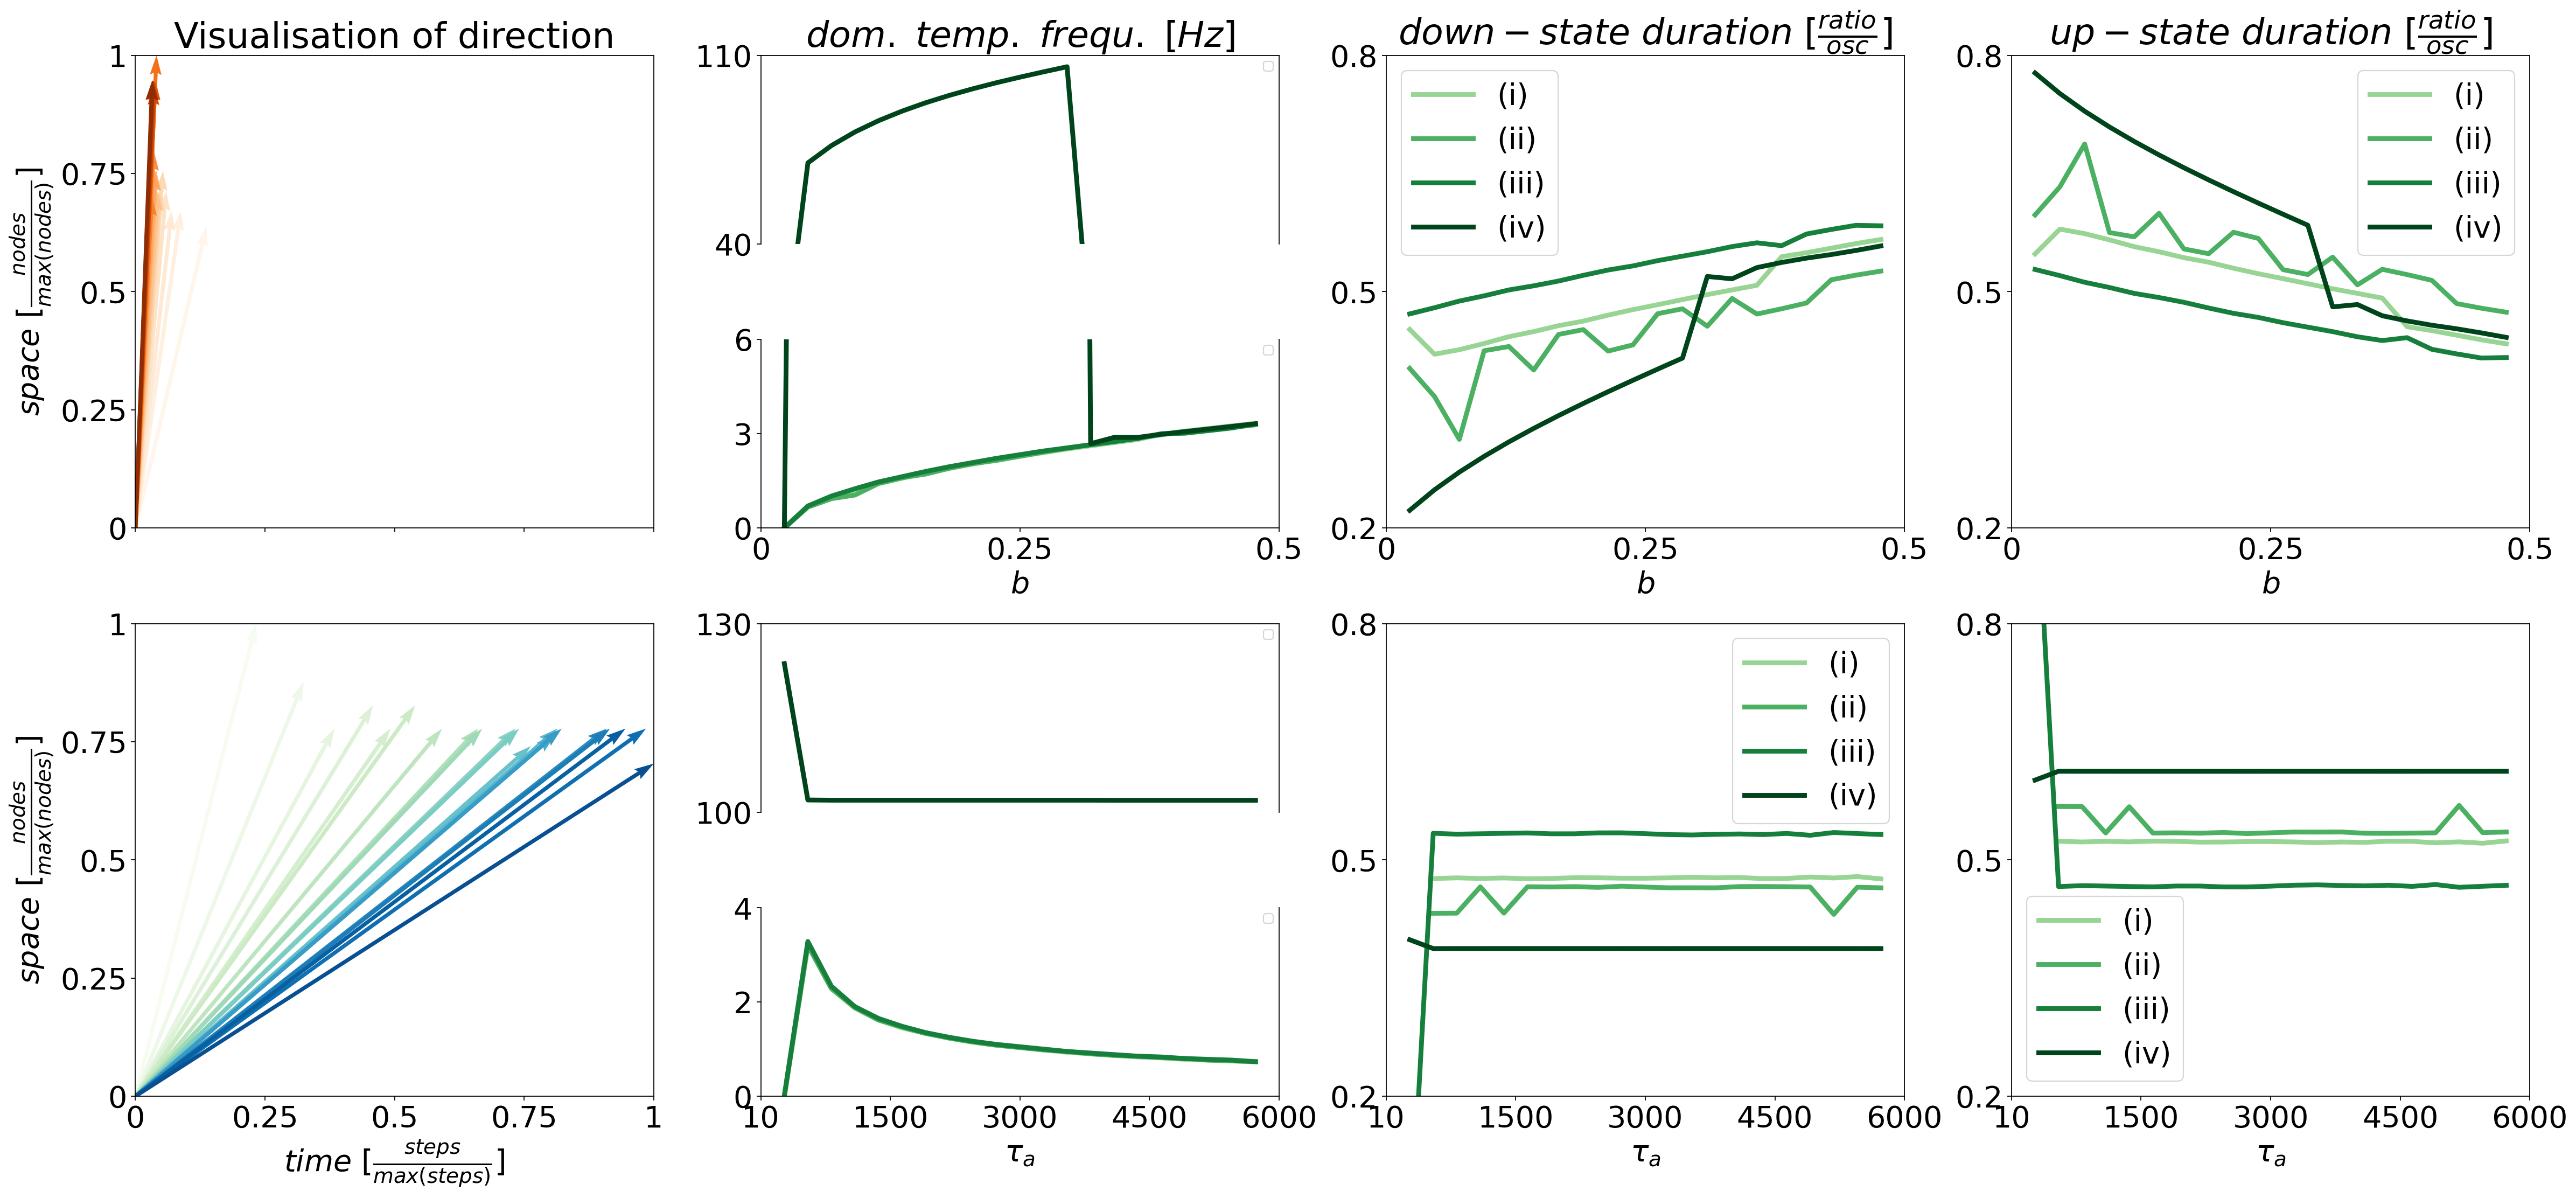

In [44]:
labels = ['(i)', '(ii)', '(iii)', '(iv)']
label_fs = 10
#fs=20
#lw=4
colors = cm.get_cmap('Greens', 6)

fig, ((ax0, ax1, ax2, ax3), 
      (ax4, ax5, ax6, ax7), 
      (ax8, ax9, ax10, ax11), 
      (ax12, ax13, ax14, ax15)) = plt.subplots(4, 4, figsize=(30,14), dpi=160)

# Use subplot2grid for the first column
ax0 = plt.subplot2grid((4, 4), (0, 0), rowspan=2, colspan=1)  # Merged for the first two rows
ax4 = plt.subplot2grid((4, 4), (2, 0), rowspan=2, colspan=1)

# Use subplot2grid for the second last  columns
ax2 = plt.subplot2grid((4, 4), (0, 2), rowspan=2, colspan=1)  # Merged for the first two rows
ax6 = plt.subplot2grid((4, 4), (2, 2), rowspan=2, colspan=1)

# Use subplot2grid for the last column
ax3 = plt.subplot2grid((4, 4), (0, 3), rowspan=2, colspan=1)  # Merged for the first two rows
ax7 = plt.subplot2grid((4, 4), (2, 3), rowspan=2, colspan=1)

for ind, pair in enumerate(b_avg_max[1:,:]):
    ax0.quiver(0, 0, pair[0], pair[1], angles='xy', scale_units='xy', scale=1, 
               color=colors_b(ind))

ax0.set_title('Visualisation of direction', fontsize=fs+5)
    
for ind, pair in enumerate(tau_avg_max[1:,:]):
    ax4.quiver(0, 0, pair[0], pair[1], angles='xy', scale_units='xy', scale=1, 
               color=colors_tau(ind))
    
for ax in [ax0, ax4]:
    ax.set_xlim([0, 1])
    ax.set_xlabel(ylabels[1], fontsize=fs)
    ax.xaxis.set_major_locator(ticker.LinearLocator(5))
    ax.set_xticklabels(labels=[0, 0.25, 0.5, 0.75, 1], fontsize=fs)
    ax.set_ylim([0, 1])
    ax.set_ylabel(ylabels[2], fontsize=fs)
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.set_yticklabels(labels=[0, 0.25, 0.5, 0.75, 1], fontsize=fs)
    
ax0.set_xticklabels(labels=[])
ax0.set_xlabel('')

ax1.set_title(r'$dom.$' + ' ' + r'$temp.$' + ' ' + r'$frequ.$' + ' ' + r'$[Hz]$', fontsize=fs+5)
ax2.set_title(r'$down-state$' + ' ' + r'$duration$' + ' ' + r'$[\frac{ratio}{osc}]$', fontsize=fs+5)
ax3.set_title(r'$up-state$' + ' ' + r'$duration$' + ' ' + r'$[\frac{ratio}{osc}]$', fontsize=fs+5)

dfList1[-1].plot(ax=ax1, x='b',  y='temp_dom_frequ', c=colors(6),
                label='%s' %labels[-1], fontsize=fs+10, linewidth = lw)

dfList2[-1].plot(ax=ax9, x='tau_a',  y='temp_dom_frequ', c=colors(6),
                label='%s' %labels[-1], fontsize=fs+10, linewidth = lw)

for idx, b_df in enumerate(dfList1):
    b_df.plot(ax=ax5, x='b',  y='temp_dom_frequ', c=colors(idx+2),
              label='%s' %labels[idx], fontsize=fs+10, linewidth = lw)
    b_df.plot(ax=ax2, x='b',  y='down_duration_ratio', c=colors(idx+2),
                  label='%s' %labels[idx], fontsize=fs+10, linewidth = lw)
    b_df.plot(ax=ax3, x='b',  y='up_duration_ratio', c=colors(idx+2),
                  label='%s' %labels[idx], fontsize=fs+10, linewidth = lw)

for idx, tau_df in enumerate(dfList2[:-1]):
    tau_df.plot(ax=ax13, x='tau_a',  y='temp_dom_frequ', c=colors(idx+2),
              label='%s' %labels[idx], fontsize=fs+10, linewidth = lw)

for idx, tau_df in enumerate(dfList2):
    tau_df.plot(ax=ax6, x='tau_a',  y='down_duration_ratio', c=colors(idx+2),
                  label='%s' %labels[idx], fontsize=fs+10, linewidth = lw)
    tau_df.plot(ax=ax7, x='tau_a',  y='up_duration_ratio', c=colors(idx+2),
                  label='%s' %labels[idx], fontsize=fs+10, linewidth = lw)

for ax in [ax6, ax7, ax2, ax3, ax6, ax7]:
    ax.set_ylim([0.2, 0.8])
    ax.yaxis.set_major_locator(ticker.LinearLocator(3))
    ax.set_yticklabels(labels=[0.2, 0.5, 0.8], fontsize=fs)
    
#for ax in [ax2, ax3, ax6, ax7]:
#    ax.set_ylim([0.2, 0.8])
#    ax.yaxis.set_major_locator(ticker.LinearLocator(3))
 #   ax.set_yticklabels(labels=[0, 0.5, 1], fontsize=fs)
    
ax1.set_ylim([40,110])
ax9.set_ylim([100,130])

ax5.set_ylim([0,6])
ax13.set_ylim([0,4])

#set high-frequ labels for b (yaxis)
ax1.yaxis.set_major_locator(ticker.LinearLocator(2))
ax1.set_yticklabels(labels=b_high_frequ_labels, fontsize=fs)

#set high-frequ labels for tau_a (yaxis)
ax9.yaxis.set_major_locator(ticker.LinearLocator(2))
ax9.set_yticklabels(labels=tau_high_frequ_labels, fontsize=fs)

#set low-frequ labels for b and omit for tau_a (yaxis)
ax5.yaxis.set_major_locator(ticker.LinearLocator(3))
ax5.set_yticklabels(labels=b_low_frequ_labels, fontsize=fs)
ax13.yaxis.set_major_locator(ticker.LinearLocator(3))
ax13.set_yticklabels(labels=[0,2,4], fontsize=fs)

for ax in [ax5, ax2, ax3]:
   #set b-axis labels
    ax.set_xlabel(r'$b$', fontsize=fs)
    ax.xaxis.set_major_locator(ticker.LinearLocator(3))
    ax.set_xticklabels(labels=b_labels, fontsize=fs)
    

for ax in [ax13, ax6, ax7]:
    #set tau_a-axis labels
    ax.set_xlabel(r'$\tau_a$', fontsize=fs)
    ax.xaxis.set_major_locator(ticker.LinearLocator(5))
    ax.set_xticklabels(labels=tau_labels, fontsize=fs)

#get rid of xaxis labels for upper plots and right
ax1.set_xticklabels(labels=[])
ax9.set_xticklabels(labels=[])


ax1.xaxis.set_major_locator(ticker.LinearLocator(0))
ax1.set_xlabel('')
ax9.xaxis.set_major_locator(ticker.LinearLocator(0))
ax9.set_xlabel('')

#ax3.scatter(0.25, 2.3, s=100, c='black', zorder=2)
#ax4.scatter(600, 2.3, s=100, c='black', zorder=2)

for ax in [ax1, ax9]:
    ax1.xaxis.set_major_locator(ticker.LinearLocator(0))
    ax9.xaxis.set_major_locator(ticker.LinearLocator(0))
    ax.spines['bottom'].set_visible(False)

for ax in [ax5, ax13]:
    ax.spines['top'].set_visible(False)

for ax in [ax1, ax2, ax3, ax5, ax9, ax6, ax7]:
    ax.legend(fontsize=fs)
    
for ax in [ax1, ax5, ax9, ax13]:
    ax.legend(labels=[])

plt.tight_layout()

plt.show()

fig.savefig('adap_features_durations.png')

/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1385/2910618473.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=[0, 0.25, 0.5, 0.75, 1], fontsize=fs)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1385/2910618473.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=[0, 0.25, 0.5, 0.75, 1], fontsize=fs)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1385/2910618473.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=[0.2, 0.5, 0.8], fontsize=fs)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1385/2910618473.py:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=[2,5,8], fontsize=fs)
/var/folders/8l/w8cdnkkj38bg2pscx__1vxth0000gn/T/ipykernel_1385/2910618473.py:68: UserWarning: FixedFormatter should only be used to

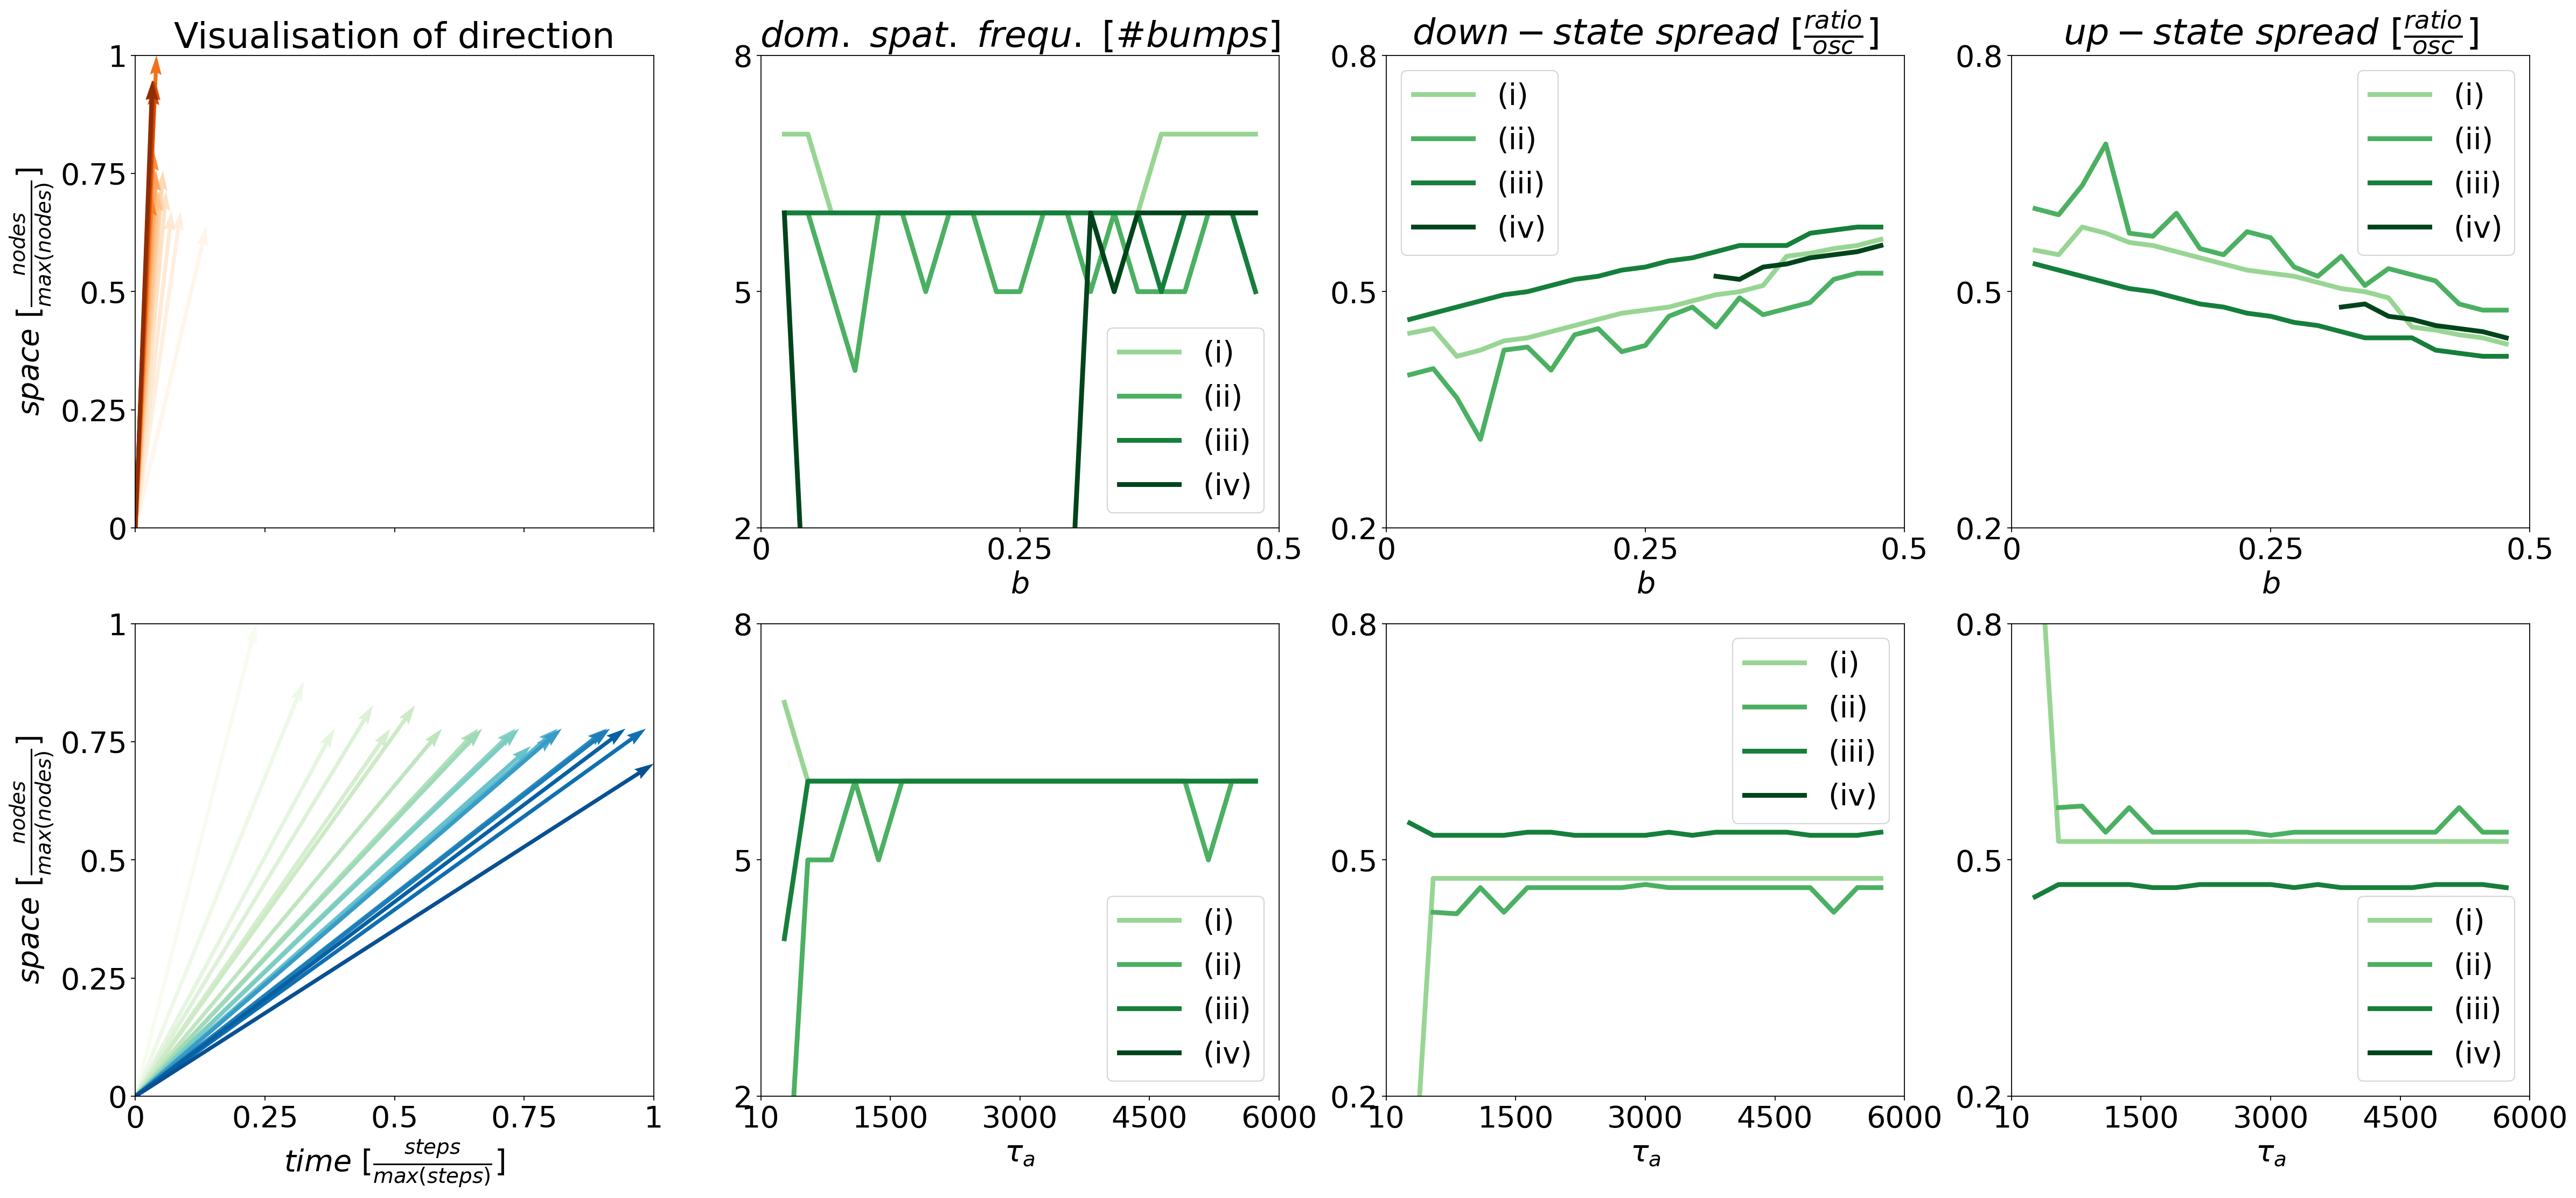

In [43]:
labels = ['(i)', '(ii)', '(iii)', '(iv)']
label_fs = 10
#fs=20
#lw=4
colors = cm.get_cmap('Greens', 6)

fig, ((ax0, ax1, ax2, ax3), 
      (ax4, ax5, ax6, ax7)) = plt.subplots(2, 4, figsize=(30,14), dpi=160)

for ind, pair in enumerate(b_avg_max[1:,:]):
    ax0.quiver(0, 0, pair[0], pair[1], angles='xy', scale_units='xy', scale=1, 
               color=colors_b(ind))

ax0.set_title('Visualisation of direction', fontsize=fs+5)
    
for ind, pair in enumerate(tau_avg_max[1:,:]):
    ax4.quiver(0, 0, pair[0], pair[1], angles='xy', scale_units='xy', scale=1, 
               color=colors_tau(ind))
    
for ax in [ax0, ax4]:
    ax.set_xlim([0, 1])
    ax.set_xlabel(ylabels[1], fontsize=fs)
    ax.xaxis.set_major_locator(ticker.LinearLocator(5))
    ax.set_xticklabels(labels=[0, 0.25, 0.5, 0.75, 1], fontsize=fs)
    ax.set_ylim([0, 1])
    ax.set_ylabel(ylabels[2], fontsize=fs)
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.set_yticklabels(labels=[0, 0.25, 0.5, 0.75, 1], fontsize=fs)
    
ax0.set_xticklabels(labels=[])
ax0.set_xlabel('')

ax1.set_title(r'$dom.$' + ' ' + r'$spat.$' + ' ' + r'$frequ.$' + ' ' + r'$[$' +'#' r'$bumps]$', fontsize=fs+5)
ax2.set_title(r'$down-state$' + ' ' + r'$spread$' + ' ' + r'$[\frac{ratio}{osc}]$', fontsize=fs+5)
ax3.set_title(r'$up-state$' + ' ' + r'$spread$' + ' ' + r'$[\frac{ratio}{osc}]$', fontsize=fs+5)


for idx, b_df in enumerate(dfList1):
    b_df.plot(ax=ax1, x='b',  y='space_dom_frequ', c=colors(idx+2),
              label='%s' %labels[idx], fontsize=fs+10, linewidth = lw)
    b_df.plot(ax=ax2, x='b',  y='down_space_ratio', c=colors(idx+2),
                  label='%s' %labels[idx], fontsize=fs+10, linewidth = lw)
    b_df.plot(ax=ax3, x='b',  y='up_space_ratio', c=colors(idx+2),
                  label='%s' %labels[idx], fontsize=fs+10, linewidth = lw)

for idx, tau_df in enumerate(dfList2):
    tau_df.plot(ax=ax5, x='tau_a',  y='space_dom_frequ', c=colors(idx+2),
              label='%s' %labels[idx], fontsize=fs+10, linewidth = lw)
    tau_df.plot(ax=ax6, x='tau_a',  y='down_space_ratio', c=colors(idx+2),
                  label='%s' %labels[idx], fontsize=fs+10, linewidth = lw)
    tau_df.plot(ax=ax7, x='tau_a',  y='up_space_ratio', c=colors(idx+2),
                  label='%s' %labels[idx], fontsize=fs+10, linewidth = lw)

for ax in [ax2, ax3, ax6, ax7]:
    ax.set_ylim([0.2, 0.8])
    ax.yaxis.set_major_locator(ticker.LinearLocator(3))
    ax.set_yticklabels(labels=[0.2, 0.5, 0.8], fontsize=fs)

for ax in [ax1, ax5]:
    ax.set_ylim([2,8])
    ax.yaxis.set_major_locator(ticker.LinearLocator(3))
    ax.set_yticklabels(labels=[2,5,8], fontsize=fs)

for ax in [ax1, ax2, ax3]:
   #set b-axis labels
    ax.set_xlabel(r'$b$', fontsize=fs)
    ax.xaxis.set_major_locator(ticker.LinearLocator(3))
    ax.set_xticklabels(labels=b_labels, fontsize=fs)
    

for ax in [ax5, ax6, ax7]:
    #set tau_a-axis labels
    ax.set_xlabel(r'$\tau_a$', fontsize=fs)
    ax.xaxis.set_major_locator(ticker.LinearLocator(5))
    ax.set_xticklabels(labels=tau_labels, fontsize=fs)

for ax in [ax1, ax2, ax3, ax5, ax6, ax7]:
    ax.legend(fontsize=fs)
    
#for ax in [ax1, ax5, ax9, ax13]:
#    ax.legend(labels=[])

plt.tight_layout()

plt.show()

fig.savefig('adaps_features_space.png')

In [ ]:
# Concatenate DataFrames along a new axis (axis=0) to stack them
tau_time_data = pd.concat([tau1_lats['#time_steps'], tau2_lats['#time_steps'], 
                           tau3_lats['#time_steps'], tau4_lats['#time_steps']], axis=1)

# Compute the variance along the stacked axis (axis=0)
tau_var_time = np.var(tau_time_data, axis=1)

# Concatenate DataFrames along a new axis (axis=0) to stack them
tau_space_data = pd.concat([tau1_lats['#nodes'], tau2_lats['#nodes'], 
                           tau3_lats['#nodes'], tau4_lats['#nodes']], axis=1)


# Compute the variance along the stacked axis (axis=0)
tau_var_space = np.var(tau_space_data, axis=1)

tau_var_df = np.array([tau_var_time, tau_var_space]).T.reshape(len(tauy_max),2)
tau_var_df

In [ ]:
#tau_times_avg_normalized = normalize(tau_avg[:, 0], 0, 1)
#tau_nodes_avg_normalized = normalize(tau_avg[:, 1], 0, 1)
#tau_avg_norm = np.array([tau_times_avg_normalized, tau_nodes_avg_normalized]).T.reshape(len(tau_times_avg_normalized),2)

In [ ]:
#tau_times_var_normalized = normalize(tau_var[:, 0], 0, 1)
#tau_nodes_var_normalized = normalize(tau_var[:, 1], 0, 1)
#tau_var_norm = np.array([tau_times_var_normalized, tau_nodes_var_normalized]).T.reshape(len(tau_times_var_normalized),2)

In [ ]:
colors_b = cm.get_cmap('Oranges', len(b_avg))
colors_tau = cm.get_cmap('Blues', len(tau_avg))

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(26,12))

for ind, (vector, variance) in enumerate(zip(b_avg, b_var)):
    ax0.quiver(*vector, angles='xy', scale_units='xy', scale=1, color=colors_b(ind))
    
    # Calculate the angle of rotation for the ellipse
    angle = np.arctan2(vector[1], vector[0]) * (180 / np.pi)
    
    ellipse = Ellipse(xy=vector, width=0.05*variance[0], height=0.05*variance[1], edgecolor='none', 
                      angle=angle, facecolor=colors_b(ind), alpha=0.5)
  #  ax0.add_patch(ellipse)

for ind, pair in enumerate(b_avg):
  #  print('b: ', pair)
    ax0.quiver(0, 0, pair[0], pair[1], angles='xy', scale_units='xy', scale=1, color=colors_b(ind))
    

for ind, pair in enumerate(tau_avg_max):
    print('tau: ', pair)
    ax1.quiver(0, 0, pair[0], pair[1], angles='xy', scale_units='xy', scale=1, 
               color=colors_tau(ind))
    
#for ind, (vector, variance) in enumerate(zip(tau_avg, tau_var)):
#    print(vector)
#    ax1.quiver(*vector, angles='xy', scale_units='xy', scale=1, color=colors_tau(ind))
    
    # Calculate the angle of rotation for the ellipse
#    angle = np.arctan2(vector[1], vector[0]) * (180 / np.pi)
    
#    ellipse = Ellipse(xy=vector, width=0.1*variance[0], height=0.1*variance[1], edgecolor='none', 
#                      angle=angle, facecolor=colors_tau(ind), alpha=0.5)
 #   ax1.add_patch(ellipse)

# Set axis limits based on the vectors
ax0.set_xlim([0, np.max(b_avg[:,0])+1])
ax0.set_ylim([0, np.max(b_avg[:,1])+1])

ax1.set_xlim([0, 1])#np.max(tau_avg[:,0])+20])
ax1.set_ylim([0, 1])#np.max(tau_avg[:,1])+2000])

In [ ]:
from matplotlib import cm

colors_b = cm.get_cmap('Oranges', len(b_avg))
colors_tau = cm.get_cmap('Blues', len(tau_avg))

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(26,12))

for ind, (vector, variance) in enumerate(zip(b_avg, b_var)):
    ax0.quiver(*vector, angles='xy', scale_units='xy', scale=1, color=colors_b(ind))
    
    # Calculate the angle of rotation for the ellipse
    angle = np.arctan2(vector[1], vector[0]) * (180 / np.pi)
    
    ellipse = Ellipse(xy=vector, width=0.05*variance[0], height=0.05*variance[1], edgecolor='none', 
                      angle=angle, facecolor=colors_b(ind), alpha=0.5)
  #  ax0.add_patch(ellipse)

for ind, pair in enumerate(b_avg):
  #  print('b: ', pair)
    ax0.quiver(0, 0, pair[0], pair[1], angles='xy', scale_units='xy', scale=1, color=colors_b(ind))
    

for ind, pair in enumerate(tau_avg):
    print('tau: ', pair)
    ax1.quiver(0, 0, pair[0], pair[1], angles='xy', scale_units='xy', scale=1, 
               color=colors_tau(ind))
    
#for ind, (vector, variance) in enumerate(zip(tau_avg, tau_var)):
#    print(vector)
#    ax1.quiver(*vector, angles='xy', scale_units='xy', scale=1, color=colors_tau(ind))
    
    # Calculate the angle of rotation for the ellipse
#    angle = np.arctan2(vector[1], vector[0]) * (180 / np.pi)
    
#    ellipse = Ellipse(xy=vector, width=0.1*variance[0], height=0.1*variance[1], edgecolor='none', 
#                      angle=angle, facecolor=colors_tau(ind), alpha=0.5)
 #   ax1.add_patch(ellipse)

# Set axis limits based on the vectors
ax0.set_xlim([0, np.max(b_avg[:,0])+1])
ax0.set_ylim([0, np.max(b_avg[:,1])+1])

ax1.set_xlim([0, np.max(tau_avg[:,0])+1])
ax1.set_ylim([0, np.max(tau_avg[:,1])+1])